[Epoch 1/10] avg_query_acc=0.3000
[Epoch 2/10] avg_query_acc=0.3000
[Epoch 3/10] avg_query_acc=0.2000
[Epoch 4/10] avg_query_acc=0.2500
[Epoch 5/10] avg_query_acc=0.4000
[Epoch 6/10] avg_query_acc=0.4000
[Epoch 7/10] avg_query_acc=0.2000
[Epoch 8/10] avg_query_acc=0.4500
[Epoch 9/10] avg_query_acc=0.2500
[Epoch 10/10] avg_query_acc=0.3500


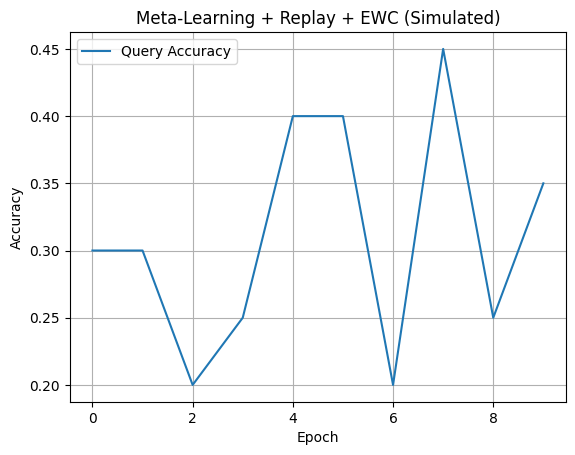

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 超参数
# -----------------------------
SEQ_LEN = 64
NUM_FEATS = 64
NUM_CLASSES = 3
INNER_LR = 0.01
LAMBDA_EWC = 0.3
REPLAY_SIZE = 32
BATCH_SIZE = 4
NUM_TASKS = 5
SUPPORT_SIZE = 4
QUERY_SIZE = 4
EPOCHS = 10

# -----------------------------
# Replay Buffer (保存原始序列)
# -----------------------------
class ReplayBuffer:
    def __init__(self, capacity=REPLAY_SIZE):
        self.capacity = capacity
        self.X = []
        self.y = []

    def add(self, X_batch, y_batch):
        for x, yv in zip(X_batch, y_batch):
            if len(self.X) < self.capacity:
                self.X.append(x)
                self.y.append(yv)
            else:
                idx = len(self.X) % self.capacity
                self.X[idx] = x
                self.y[idx] = yv

    def sample(self, batch_size=BATCH_SIZE):
        if len(self.X) == 0:
            return np.empty((0, SEQ_LEN, NUM_FEATS)), np.empty((0,), dtype=int)
        idxs = np.random.choice(len(self.X), min(batch_size, len(self.X)), replace=False)
        Xs = np.stack([self.X[i] for i in idxs])
        ys = np.array([self.y[i] for i in idxs], dtype=int)
        return Xs, ys

# -----------------------------
# 分类头 forward + grad + EWC
# -----------------------------
def dense_forward_and_update(encoder_feat, y, weights, bias,
                             prev_weights, prev_bias, fisher_diag,
                             lr=INNER_LR, lambda_ewc=LAMBDA_EWC):
    logits = encoder_feat @ weights + bias
    exp_logits = np.exp(logits - np.max(logits))
    probs = exp_logits / np.sum(exp_logits)
    grad_out = probs
    grad_out[y] -= 1.0

    for f in range(NUM_FEATS):
        for c in range(NUM_CLASSES):
            g = grad_out[c] * encoder_feat[f]
            g += lambda_ewc * fisher_diag[f, c] * (weights[f, c] - prev_weights[f, c])
            weights[f, c] -= lr * g

    for c in range(NUM_CLASSES):
        g = grad_out[c] + lambda_ewc * (bias[c] - prev_bias[c])
        bias[c] -= lr * g

# -----------------------------
# inner-loop update with Replay + EWC
# -----------------------------
def inner_loop_update(X_support, y_support, replay: ReplayBuffer,
                      weights, bias, prev_weights, prev_bias, fisher_diag,
                      encoder_fn):
    # 合并 replay + support
    X_replay, y_replay = replay.sample(BATCH_SIZE)
    X_batch = np.concatenate([X_replay, X_support], axis=0)
    y_batch = np.concatenate([y_replay, y_support], axis=0)

    # encoder 前向
    encoder_feats_batch = encoder_fn(X_batch)

    # inner-loop 更新
    for x, yv in zip(encoder_feats_batch, y_batch):
        dense_forward_and_update(x, yv, weights, bias, prev_weights, prev_bias, fisher_diag)

    # 将 support 加入 replay
    replay.add(X_support, y_support)

# -----------------------------
# 模拟 TFLite encoder 输出
# -----------------------------
def mock_encoder(X_batch):
    batch_size = X_batch.shape[0]
    return np.random.randn(batch_size, NUM_FEATS).astype(np.float32)

# -----------------------------
# 评估 accuracy
# -----------------------------
def evaluate(X, y, weights, bias, encoder_fn):
    encoder_feats = encoder_fn(X)
    correct = 0
    for xi, yi in zip(encoder_feats, y):
        pred = np.argmax(xi @ weights + bias)
        if pred == yi:
            correct += 1
    return correct / len(y)

# -----------------------------
# 初始化
# -----------------------------
weights = np.zeros((NUM_FEATS, NUM_CLASSES), dtype=np.float32)
bias = np.zeros(NUM_CLASSES, dtype=np.float32)
prev_weights = np.zeros_like(weights)
prev_bias = np.zeros_like(bias)
fisher_diag = np.ones_like(weights)
replay = ReplayBuffer(REPLAY_SIZE)

# -----------------------------
# 多轮任务训练
# -----------------------------
acc_history = []

for epoch in range(EPOCHS):
    task_acc = 0
    for t in range(NUM_TASKS):
        # support + query
        X_support = np.random.randn(SUPPORT_SIZE, SEQ_LEN, NUM_FEATS).astype(np.float32)
        y_support = np.random.randint(0, NUM_CLASSES, size=(SUPPORT_SIZE,))
        X_query = np.random.randn(QUERY_SIZE, SEQ_LEN, NUM_FEATS).astype(np.float32)
        y_query = np.random.randint(0, NUM_CLASSES, size=(QUERY_SIZE,))

        # inner-loop 更新
        inner_loop_update(X_support, y_support, replay,
                          weights, bias, prev_weights, prev_bias, fisher_diag,
                          encoder_fn=mock_encoder)

        # query accuracy
        acc = evaluate(X_query, y_query, weights, bias, encoder_fn=mock_encoder)
        task_acc += acc

    avg_acc = task_acc / NUM_TASKS
    acc_history.append(avg_acc)
    print(f"[Epoch {epoch+1}/{EPOCHS}] avg_query_acc={avg_acc:.4f}")

# -----------------------------
# 可视化
# -----------------------------
plt.figure()
plt.plot(acc_history, label="Query Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Meta-Learning + Replay + EWC (Simulated)")
plt.grid(True)
plt.legend()
plt.show()
